# House price prediction from Airbnb housing and socio-demographic indexes from New York City, 2017

* Brocco Mattia **|** 873058
* Piccolo Giulio **|** 874727

In [1]:
import dtale
import geopy
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
%matplotlib inline

import Data_cleaner as cle
%reload_ext autoreload
%autoreload 2

In [ ]:
#################### IDEAS
# From Block, Lot and Borough CREATE a map to locate each building

In [ ]:
### URL datasets
# https://www.kaggle.com/muonneutrino/new-york-city-census-data
# https://www.kaggle.com/new-york-city/nyc-property-sales#nyc-rolling-sales.csv

### Giulio
# filename = "/Users/giuliopiccolo/Desktop/lab/project/dataset/NYC_Airbnb_2017.csv"
# filename1 = "/Users/giuliopiccolo/Desktop/lab/project/dataset/NYC_house_price.csv"

### Mattia
# filename = "/Users/matti/Desktop/BA Second Year/3. Lab of Information systems and analytics/3. Project/NYC_Airbnb_2017.csv"
# filename1 = "/Users/matti/Desktop/BA Second Year/3. Lab of Information systems and analytics/3. Project/NYC_house_price.csv"

In [2]:
airbnb = pd.read_csv("/Users/matti/Desktop/BA Second Year/3. Lab of Information systems and analytics/3. Project/NYC_Airbnb_2017.csv", low_memory = False)
house_price = pd.read_csv("/Users/matti/Desktop/BA Second Year/3. Lab of Information systems and analytics/3. Project/NYC_house_price.csv")
crashes = pd.read_csv("/Users/matti/Desktop/BA Second Year/3. Lab of Information systems and analytics/3. Project/NYC_collision.csv", low_memory = False)

## Data cleaning of NYC House Price dataset

To assess the proportion to cut off the mean to compute the trimmed mean, we performed this analysis and the graphic result shows how a good approximation can be made at the cutoff of:
* 0.011 for "land_square_feet"
* 0.08 for "gross_square_feet"

```python
# This study was performed during data cleaning operations of the abovementioned dataframe
x_var = np.arange(0, 0.5, 0.001)
y_var = np.array( [round(scipy.stats.trim_mean(df_price['land_square_feet'], x), 3) for x in x_var] )
z_soglia = [1650 for x in range(len(x_var))] # visual check for interception with y_var

plt.figure(figsize=(15,6))
plt.plot(y_var, linewidth = 5, color = "#A4063E")
plt.plot(z_soglia, linewidth = 2, color = "blue")

def find_nearest(array, value):
    """
    * idx is the position (index) of the value we are looking for,
    using the function armin to find the minimum value
    * then return the actual value found
    """
    idx = (np.abs(array - value)).argmin()
    return array[idx]

y_var_list = list(y_var)
x_var_list = list(x_var)

# Visualize the threshold for the truncated mean
print(  x_var_list[y_var_list.index(find_nearest(y_var, z_soglia[0]))]  )
```

## Data cleasing of NYC house prices dataset

In [3]:
cleaner = cle.cleaners()
df_price = cleaner.house_price_cleaner(house_price)

In [ ]:
# Heatmap of correlations
plt.figure(figsize = (10,8))
corr = df_price.corr()
sns.heatmap(corr, annot = True)

#### Code to possibly slice dataset according to price thresholds
#df_sliced = df_price["sale_price"].copy()
#df_sliced_list = [x for x in df_sliced.tolist() if 100000 < x < 10000000]
#sns.distplot(df_sliced_list)

In [ ]:
# Barplot of available values
gess = df_price.copy()
count = []
for var in gess.columns:
    length = gess[var].count()
    count.append(length)
    
count_pct = np.round(100 * pd.Series(count) / len(gess), 2)
print(count_pct.tolist())

plt.figure(figsize=(10,6), dpi = 300)
plt.barh(gess.columns, count_pct)
plt.title('Count of available data in percent', fontsize=15)
plt.show()

In [ ]:
# TO ADD
# interative data visualization using plotly package (https://plot.ly)

## Data cleasing of NYC car accidents dataset

In [4]:
df_crash = cleaner.crash_cleaner(crashes)

### How many missing values do we have?

The following heatmap serves as a way to visualize the extent to which a column contains empty cells.
- Crashes that involve more than 2 vehicles are higly populated of missing values as expected, since most of the time crashes involves two vehicles only
- The 'borough' column needs to be improved, and we did it by gathering the coordinates of the accident to identify the borough name

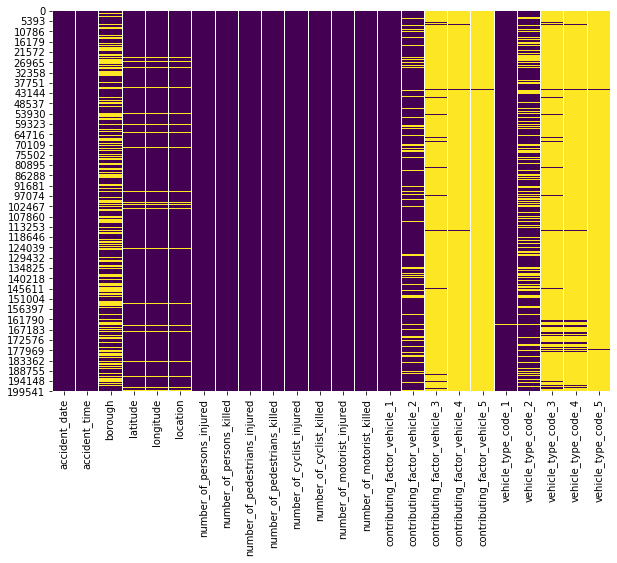

In [5]:
crash_to_viz = df_crash.copy()
plt.figure(figsize=(10,7))
sns.heatmap(crash_to_viz.isnull(), cbar = False, cmap = 'viridis')

In [6]:
from math import cos, asin, sqrt
# Haversine formula
def distance_viz(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # math.PI / 180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(a)) #2 * R; R = 6371 km

# get the closest point 
def closest_viz(data, v):
    return min(data, key = lambda p: distance_viz(v[0], v[1], p[0], p[1]) )

borough_dict = {"BRONX" : [40.837048, -73.865433], "BROOKLYN" : [40.650002, -73.949997],
                "MANHATTAN" : [40.758896, -73.985130], "QUEENS" : [40.742054,-73.769417],
                "STATEN ISLAND" : [40.579021,-74.151535]}

boroughs = [(*value, key) for key, value in borough_dict.items()]

crash_to_viz['borough'] = crash_to_viz.apply( lambda row:
    closest_viz(boroughs, [row['latitude'], row['longitude']])[2]
    if row['borough'] is None else row['borough'], axis=1)

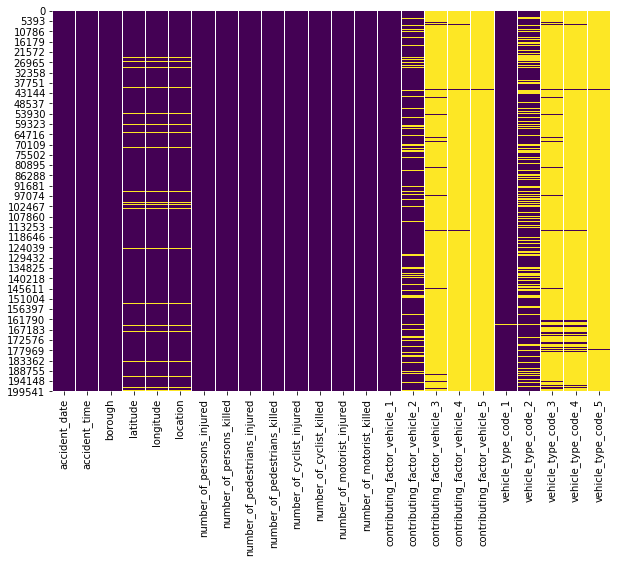

In [7]:
# The same heatmap is performed to check the quantity of NaN values after the abovementioned map has been applied
plt.figure(figsize=(10,7))
sns.heatmap(crash_to_viz.isnull(), cbar = False, cmap = 'viridis')

## NYC Neighborhoods coordinates and neigborhoods applied to all dataframes

In [8]:
neighborhoods = pd.read_excel("/Users/matti/Desktop/BA Second Year/3. Lab of Information systems and analytics/3. Project/NYC_neighborhoods.xlsx")
neighborhoods = neighborhoods.rename(columns = str.lower)

neigh_copy = neighborhoods.copy()
neigh_copy['neighborhood'] = neigh_copy['neighborhood'].str.capitalize()
neigh_copy = neigh_copy.drop_duplicates(neigh_copy.columns, keep = "last")
neigh_list = [tuple(x) for x in neigh_copy.values.tolist()]

In [9]:
df_price = df_price.merge(neighborhoods, on = "neighborhood")
df_crash['neighborhood'] = df_crash.apply( lambda row:
                                          cleaner.closest(neigh_list, [row['latitude'], row['longitude']])[0], axis=1)

## Data cleasing of Airbnbs of NYC dataset

The "airbnb" dataframe required only a little effort in cleasing operations. As shown through the chunck below, which output is $2.741 \% $, this dataset is characterized by a very low rate of empty cells.
```python
print("Missing values: ",  df_blocks.isnull().sum().sum() , " | Perc of total: ",
      round(100*df_blocks.isnull().sum().sum() / (df_blocks.shape[0]*df_blocks.shape[1]), 3))
```
So, we decided to all drop the rows that presented NaN values, since they represent only a small share of the total.

```python
total = df1.isnull().sum().sort_values(ascending = False)
percent = (df1.isnull().sum()/df1.isnull().count()).sort_values(ascending = False)

missing_data = pd.concat([total, percent], axis = 1, keys = ['NAs', 'Percent']) # df with columns, nan values and %
plt.plot( missing_data['Percent'] )
missing_data.drop(missing_data[missing_data.Percent < 0.2].index, inplace = True)
```
After a further evaluation of the columns, we assessed that only ```"reviews_per_month"``` and ```"last_review"``` had more than more than 20% of the whole column filled with NaN values. So, we dropped those two columns and used ```.dropna()``` to delete other few rows with any NaN values.

In [10]:
df_airbnb = cleaner.airbnb_cleaner(airbnb)
df_airbnb

True


,id,name,host_id,host_name,borough,neighborhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,16457286,Quite room in Shared Apartment,11796099,Shanell,Brooklyn,Bedford-Stuyvesant,40.685559,-73.940650,Private room,38,14,2,1,0
1,1356652,COZY ROOM IN BEDFORD-STUYVESANT,4508795,Darlene,Brooklyn,Bedford-Stuyvesant,40.683917,-73.934671,Private room,90,2,2,1,365
2,775016,Reggae Den Sub Level Apartment,4088378,Karin,Brooklyn,Bedford-Stuyvesant,40.687344,-73.938055,Private room,90,2,1,1,365
3,773497,Great spot in Brooklyn,4081688,Santiago,Brooklyn,Bedford-Stuyvesant,40.694073,-73.945514,Shared room,200,1,0,1,365
4,8468835,Private room in Brooklyn,6518093,Mathilde,Brooklyn,Bedford-Stuyvesant,40.679685,-73.907642,Private room,50,1,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48615,6405051,Spacious and Artsy Brooklyn Escape,24018734,Ari&Remy,Brooklyn,Bedford-Stuyvesant,40.692096,-73.960232,Private room,55,4,16,1,170
48616,1869685,Cozy apartment available!,9745149,Idoline,Brooklyn,Bedford-Stuyvesant,40.681847,-73.953359,Entire home/apt,75,7,2,1,261
48617,3697194,Private Room 15 min from Manhattan,18834029,Stephen,Brooklyn,Bedford-Stuyvesant,40.679695,-73.948574,Private room,75,1,0,1,179
48618,18394404,Bedford Apartment In NYC,16905175,Shuhan,Brooklyn,Bedford-Stuyvesant,40.689866,-73.953985,Private room,80,7,0,1,0


## Merge of all datasets

Il dataset che dobbiamo ottenere ha come riga una casa, le colonne riguardanti gli incidenti e gli airbnb sono mergate rispetto al quartiere di appartenenza della casa.
- ogni dataset va trasformato (tipo pivot) in modo che abbia come riga un quartiere e come colonna degli "aggregate" per ogni quartiere
- poi si fa un merge degli altri due addosso a df_price

ES: Airbnb
- drop delle colonne "id","name","host_id","host_name","borough"
- COLONNE: Neighborhood, Lat, Long, Moda di romm_type, media di price, media di min_price, media di reviews, media di listings, media di availability /// RIGHE: tante quante sono i quartieri




Tutte le abitazione nello stesso quartiere avranno le stesse informazioni rispetto agli airbnb.

In [11]:
df_airbnb

,id,name,host_id,host_name,borough,neighborhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,16457286,Quite room in Shared Apartment,11796099,Shanell,Brooklyn,Bedford-Stuyvesant,40.685559,-73.940650,Private room,38,14,2,1,0
1,1356652,COZY ROOM IN BEDFORD-STUYVESANT,4508795,Darlene,Brooklyn,Bedford-Stuyvesant,40.683917,-73.934671,Private room,90,2,2,1,365
2,775016,Reggae Den Sub Level Apartment,4088378,Karin,Brooklyn,Bedford-Stuyvesant,40.687344,-73.938055,Private room,90,2,1,1,365
3,773497,Great spot in Brooklyn,4081688,Santiago,Brooklyn,Bedford-Stuyvesant,40.694073,-73.945514,Shared room,200,1,0,1,365
4,8468835,Private room in Brooklyn,6518093,Mathilde,Brooklyn,Bedford-Stuyvesant,40.679685,-73.907642,Private room,50,1,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48615,6405051,Spacious and Artsy Brooklyn Escape,24018734,Ari&Remy,Brooklyn,Bedford-Stuyvesant,40.692096,-73.960232,Private room,55,4,16,1,170
48616,1869685,Cozy apartment available!,9745149,Idoline,Brooklyn,Bedford-Stuyvesant,40.681847,-73.953359,Entire home/apt,75,7,2,1,261
48617,3697194,Private Room 15 min from Manhattan,18834029,Stephen,Brooklyn,Bedford-Stuyvesant,40.679695,-73.948574,Private room,75,1,0,1,179
48618,18394404,Bedford Apartment In NYC,16905175,Shuhan,Brooklyn,Bedford-Stuyvesant,40.689866,-73.953985,Private room,80,7,0,1,0


## First try of ML Prediction

Steps to follow:
1. Descriptive analysis on the Data – 50% time
2. Data treatment (Missing value and outlier fixing) – 40% time
3. Data Modelling – 4% time
4. Estimation of performance – 6% time


STEP 1:
1. Identify ID, Input (columns of df_price) and Target (house price) features
2. Identify categorical and numerical features
3. Identify columns with missing values (already done)

In [ ]:
price_train = df_price.copy()
price_train = price_train.loc[0:500]

In [ ]:
df_census.iloc[1]

In [ ]:
price_train.dtypes

In [ ]:
r = np.corrcoef(price_train["total_units"],
                price_train["sale_price"])
r

In [ ]:
plt.scatter(price_train["total_units"],
                price_train["sale_price"])

In [ ]:
print( len([val for val in df_price["sale_price"] if val < 5000]) )

In [ ]:
len(np.arange(2000000, 200000000, 5000))

In [ ]:
x_var = np.arange(2000000, 200000000, 5000)
y_var = np.array( [len( [val for val in df_price["sale_price"] if val < x] ) for x in x_var] )
#z_soglia = [1650 for x in range(len(x_var))] # visual check for interception with y_var

plt.figure(figsize=(18,7))
plt.title("Andamento del numero di righe rispetto alla soglia fissata (x < soglia)")
plt.axvline(x = 2000000, color = "red", linewidth = 2)
#plt.plot(y_var, linewidth = 5, color = "#A4063E")
plt.scatter(x_var, y_var)
#plt.plot(y_var, linewidth = 5, color = "#A4063E")
#plt.plot(z_soglia, linewidth = 2, color = "blue")

In [ ]:
price_over_2M = [x for x in df_price["sale_price"].tolist() if 2000000 < x < 200000000]
price_over_2M[0]

In [ ]:
sns.distplot(price_over_2M, axlabel = "sale_price")

In [ ]:
sns.kdeplot([x for x in df_price["sale_price"].tolist() if 10000 < x < 2000000])
sns.kdeplot([x for x in df_price["sale_price"].tolist() if 20000 < x < 2000000])
sns.kdeplot([x for x in df_price["sale_price"].tolist() if 50000 < x < 2000000])
#sns.kdeplot([x for x in df_price["sale_price"].tolist() if 1000000 < x < 2000000])

In [ ]:
sns.distplot([x for x in df_price["sale_price"].tolist() if 10000 < x < 2000000], axlabel = "sale_price")

In [ ]:
max(df_price["sale_price"])

In [ ]:
asse_x = range(69607)
asse_y = sorted(df_price["sale_price"])
plt.scatter(asse_x, asse_y)

In [ ]:
list_price = df_price['neighborhood'].tolist()
list_price = list(dict.fromkeys(list_price))
list_price  = [x.lower() for x in list_price]

list_census = df_census["County"].tolist()
list_census = list(dict.fromkeys(list_census))

list_df1 = df1["neighbourhood"].tolist()
list_df1 = list(dict.fromkeys(list_df1))
list_df1  = [x.lower() for x in list_df1]

In [ ]:
print(list_price)

In [ ]:
print(list_df1)

In [ ]:
list_census_state = df_blocks["State"].tolist()
list_census_state = list(dict.fromkeys(list_census_state))

In [ ]:
list_census_state

In [ ]:
print( len([x for x in list_price if x in list_df1]) )

In [ ]:
mylist2 = df_airbnb['neighbourhood'].tolist()
mylist2 = list(dict.fromkeys(mylist2))
mylist2

In [ ]:
mylist[197]#.index("WOODSIDE")